In [32]:
import pandas as pd
import geopandas as gpd
from shapely import wkb
import h3
from shapely.geometry import Polygon, MultiPolygon, LineString
from shapely.ops import transform
import shapely.wkb as swkb
from functools import partial
import pyproj
import matplotlib.pyplot as plt
import rtree
import osmnx as ox
from shapely.ops import unary_union
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') 



In [34]:
amsterdam = pd.read_parquet("amsterdam_bike_paths_extended.parquet")
cracow = pd.read_parquet("krakow_bike_paths_extended.parquet")

In [35]:
def extract_features(series):
    dict_of_lists = {}
    for d in series:
        for key, value in d.items():
            dict_of_lists.setdefault(key, []).append(value)
            
    return pd.DataFrame(data=dict_of_lists)

def create_gdf(df):
    df['geometry'] = df['geometry'].apply(lambda x: swkb.loads(x, hex = True))
    gdf = gpd.GeoDataFrame(data=df, geometry='geometry')
    gdf = gdf.set_crs('EPSG:4326')
    return gdf
gdf_ams = create_gdf(amsterdam)
gdf_krk = create_gdf(cracow)
gdf_ams

id                                               tags  \
0        4264947  {'abandoned:railway': None, 'access': None, 'a...   
1        4270806  {'abandoned:railway': None, 'access': None, 'a...   
2        4305753  {'abandoned:railway': None, 'access': None, 'a...   
3        4363637  {'abandoned:railway': None, 'access': None, 'a...   
4        4364612  {'abandoned:railway': None, 'access': 'yes', '...   
...          ...                                                ...   
8613  1279692697  {'abandoned:railway': None, 'access': None, 'a...   
8614  1279692698  {'abandoned:railway': None, 'access': None, 'a...   
8615  1279692703  {'abandoned:railway': None, 'access': None, 'a...   
8616  1279692704  {'abandoned:railway': None, 'access': None, 'a...   
8617  1280382142  {'abandoned:railway': None, 'access': None, 'a...   

                                               geometry  
0     LINESTRING (4.92236 52.36544, 4.92237 52.36543...  
1     LINESTRING (4.93089 52.36596, 4.93090 52.36585...  
2       LINESTRING (4.86787 52.32198, 4.86787 52.32192)  
3     LINESTRING (4.91538 52.37115, 4.91544 52.37118...  
4     LINESTRING (4.92291 52.37384, 4.92291 52.37389...  
...                                                 ...  
8613  LINESTRING (4.96860 52.37958, 4.96858 52.37956...  
8614  LINESTRING (4.96840 52.37969, 4.96838 52.37968...  
8615  LINESTRING (4.96858 52.37983, 4.96845 52.37992...  
8616    LINESTRING (4.96882 52.37971, 4.96858 52.37983)  
8617  LINESTRING (4.88000 52.34709, 4.88031 52.34687...  

[8618 rows x 3 columns]

Text(492.9494949494949, 0.5, 'Szerokość geograficzna')

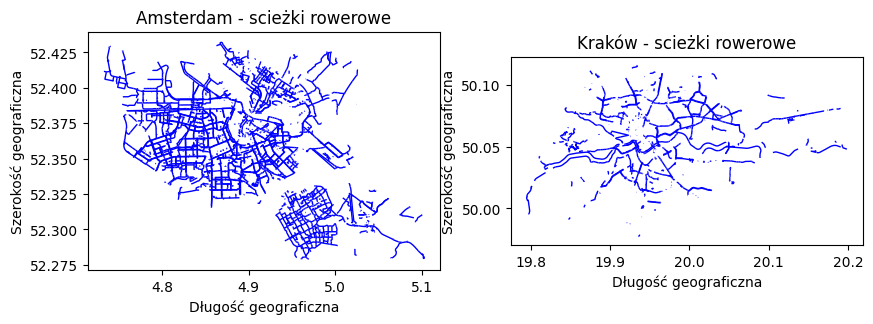

In [38]:
fig, axes = plt.subplots(1,2, figsize = [10, 10])
gdf_ams.plot(ax = axes[0], linewidth = 1, edgecolor = 'blue')

axes[0].set_title('Amsterdam - scieżki rowerowe')
axes[0].set_xlabel('Długość geograficzna')
axes[0].set_ylabel('Szerokość geograficzna')

gdf_krk.plot(ax = axes[1], linewidth = 1, edgecolor = 'blue')

axes[1].set_title('Kraków - scieżki rowerowe')
axes[1].set_xlabel('Długość geograficzna')
axes[1].set_ylabel('Szerokość geograficzna')

In [39]:
# Generowanie heksagonów H3 na obszarze Amsterdamu
def create_h3_hex_grid(df,bounds,epsg=4326):
    resolution = 8  # Rezolucja H3, im wyższa liczba, tym mniejsze heksagony
    buffer = 0.01
    h3_indices = h3.polyfill(
        {
            "type": "Polygon",
            "coordinates": [
                [
                    [bounds["west"], bounds["north"]],
                    [bounds["east"], bounds["north"]],
                    [bounds["east"], bounds["south"]],
                    [bounds["west"], bounds["south"]],
                    [bounds["west"], bounds["north"]],
                ]
            ],
        },
        resolution,
    )
    
    # Konwersja H3 do GeoDataFrame
    hexagons = []
    for h in h3_indices:
        hex_boundary = h3.h3_to_geo_boundary(h, geo_json=True)
        hex_boundary = [(lng, lat) for lat, lng in hex_boundary]
        hex_boundary.append(hex_boundary[0])  # Zamknięcie obwodu heksagonu
        hexagons.append({
            'geometry': Polygon(hex_boundary),
            'h3_index': h
        })
    
    gdf_hex = gpd.GeoDataFrame(hexagons)
    gdf_hex = gdf_hex.set_crs(epsg=epsg)
    
    return gdf_hex
 
# Funkcja przypisująca ścieżki rowerowe do heksagonów
def assign_hexagon(geometry, resolution):
    centroid = geometry.centroid
    return h3.geo_to_h3(centroid.y, centroid.x, resolution)



## Siatka hex z mapą

In [41]:
#Współrzędne granic Amsterdamu i Krakowa
amsterdam_bounds = {"north": 52.441157,"south": 52.2688,"east": 5.1127658,"west": 4.728073}
cracow_bounds = {"north":50.1257,"south":49.9639,"east": 20.215,"west":19.7946}

gdf_ams['h3_index'] = gdf_ams['geometry'].apply(assign_hexagon, resolution=8)
gdf_krk['h3_index'] = gdf_krk['geometry'].apply(assign_hexagon, resolution=8)


gdf_krk_hex = create_h3_hex_grid(gdf_krk,cracow_bounds)    
gdf_ams_hex = create_h3_hex_grid(gdf_ams,amsterdam_bounds)    

amsterdam_area = ox.geocode_to_gdf('Amsterdam, Netherlands')
cracow_area = ox.geocode_to_gdf('Kraków')




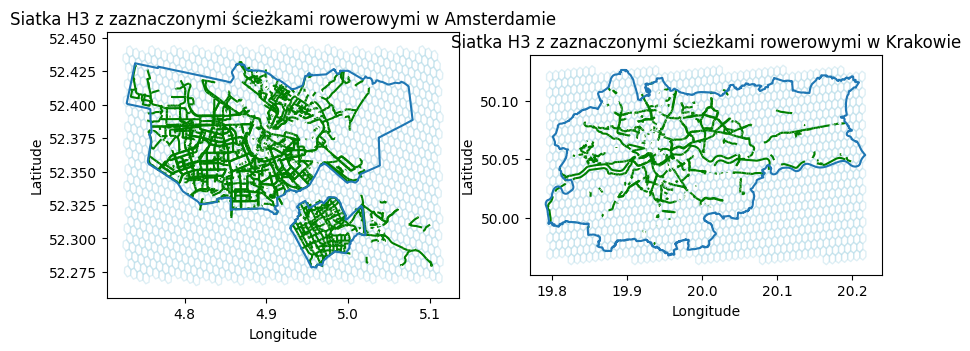

In [42]:
# Wizualizacja
fig, ax = plt.subplots(1,2,figsize=(10, 10))
gdf_ams_hex.plot(ax=ax[0], facecolor='none', edgecolor='lightblue',alpha=0.4)
gdf_ams.plot(ax=ax[0], color='green')
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
ax[0].set_title('Siatka H3 z zaznaczonymi ścieżkami rowerowymi w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

gdf_krk_hex.plot(ax=ax[1], facecolor='none', edgecolor='lightblue',alpha=0.4)
gdf_krk.plot(ax=ax[1], color='green')
cracow_area['geometry'].boundary.plot(ax=ax[1])

ax[1].set_title('Siatka H3 z zaznaczonymi ścieżkami rowerowymi w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

plt.show()

## Przycięcie map i heksagonów

In [44]:

def crop_hex_grid(gdf_hex,gdf_bike,gdf_area,epsg):
    gdf_bike = gdf_bike.to_crs(epsg=epsg)
    gdf_hex = gdf_hex.to_crs(epsg=epsg)
    gdf_area = gdf_area.to_crs(epsg=epsg)
    gdf_hex['bike_path_length'] = 0.0
    gdf_hex['within_city'] = False

    for i, polygon in gdf_hex.iterrows():
        clipped = gdf_bike.clip(polygon.geometry)
        within_city = polygon.geometry.intersects(gdf_area.geometry)
        gdf_hex.loc[i,'bike_path_length'] = clipped.length.sum()
        gdf_hex.loc[i,'within_city'] = within_city[0]

    gdf_hex = gdf_hex[(gdf_hex['within_city'] == True) | (gdf_hex['bike_path_length'] > 0)]
    gdf_hex = gdf_hex.to_crs(epsg=4326)
    del gdf_hex['within_city']
    
    return gdf_hex

gdf_ams_hex = crop_hex_grid(gdf_ams_hex, gdf_ams, amsterdam_area, 2180)
gdf_krk_hex = crop_hex_grid(gdf_krk_hex, gdf_krk, cracow_area, 2180)


Text(492.9494949494949, 0.5, 'Latitude')

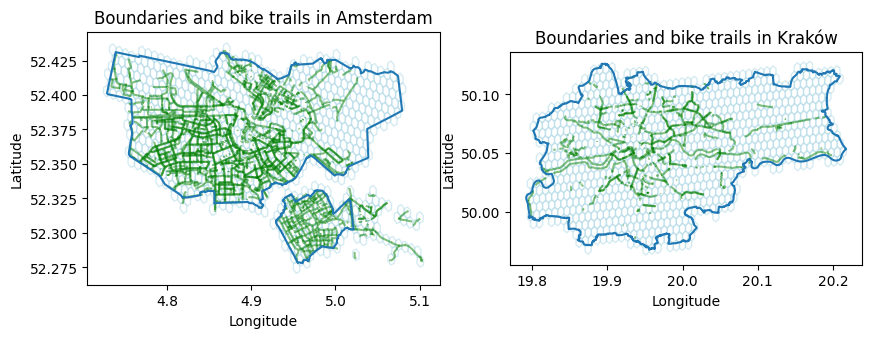

In [45]:
fig, ax = plt.subplots(1,2,figsize = (10,10))
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5)
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5)
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
# Set plot title and labels
ax[0].set_title('Boundaries and bike trails in Amsterdam')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5)
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5)
cracow_area['geometry'].boundary.plot(ax=ax[1])
# Set plot title and labels
ax[1].set_title('Boundaries and bike trails in Kraków')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

## Hex razem z policzoną długością ścieżki rowerowej

In [49]:
gdf_ams_hex

geometry         h3_index  \
0     POLYGON ((4.94029 52.36269, 4.94427 52.36389, ...  887ab60b33fffff   
1     POLYGON ((4.81067 52.41144, 4.81465 52.41264, ...  887ab6180dfffff   
2     POLYGON ((4.85620 52.36929, 4.86019 52.37049, ...  887ab618a5fffff   
3     POLYGON ((4.94420 52.29200, 4.94818 52.29321, ...  887ab608c1fffff   
4     POLYGON ((5.00176 52.36127, 5.00574 52.36247, ...  887ab646cbfffff   
...                                                 ...              ...   
1376  POLYGON ((4.80796 52.38669, 4.81195 52.38789, ...  887ab61819fffff   
1377  POLYGON ((4.86603 52.42410, 4.87002 52.42530, ...  887ab61933fffff   
1380  POLYGON ((4.76106 52.41648, 4.76505 52.41768, ...  887ab61a01fffff   
1383  POLYGON ((4.85215 52.33214, 4.85614 52.33334, ...  887ab6016dfffff   
1386  POLYGON ((5.00703 52.30299, 5.01101 52.30419, ...  887ab609bbfffff   

      bike_path_length  
0          2947.034061  
1             0.000000  
2          2252.128242  
3           483.940561  
4           702.617398  
...                ...  
1376       2972.080397  
1377         80.911623  
1380        328.553654  
1383       2704.204141  
1386          0.000000  

[752 rows x 3 columns]

In [50]:
gdf_krk_hex

geometry         h3_index  \
0     POLYGON ((19.99952 50.04525, 19.99550 50.04262...  885262c0c9fffff   
1     POLYGON ((19.90675 50.03072, 19.90273 50.02809...  885262ce29fffff   
2     POLYGON ((19.94317 50.01301, 19.93915 50.01038...  885262c19dfffff   
3     POLYGON ((20.14051 50.10525, 20.13649 50.10261...  885262d449fffff   
4     POLYGON ((20.00368 50.02488, 19.99965 50.02225...  885262c019fffff   
...                                                 ...              ...   
1207  POLYGON ((19.93053 50.11542, 19.92651 50.11279...  885262c517fffff   
1210  POLYGON ((19.90275 50.02349, 19.89873 50.02086...  885262ce2dfffff   
1213  POLYGON ((19.80996 50.02276, 19.80594 50.02013...  885262cdebfffff   
1215  POLYGON ((19.93116 49.99132, 19.92714 49.98869...  885262c1abfffff   
1217  POLYGON ((19.99529 50.07941, 19.99127 50.07678...  885262c767fffff   

      bike_path_length  
0             0.000000  
1           529.324034  
2          1388.364807  
3             0.000000  
4             0.000000  
...                ...  
1207          0.000000  
1210       1403.052406  
1213        511.863124  
1215          0.000000  
1217        422.841644  

[841 rows x 3 columns]

## Pozostałe argumenty 


#### -  długość dróg głównych i chodników



In [53]:
def calculate_road_lengths(amsterdam_bounds, gdf_ams_hex,hex_area):
    # Get road and walk networks
    Ams_roads = ox.graph_from_bbox(bbox=(amsterdam_bounds['north'],
                                         amsterdam_bounds['south'],
                                         amsterdam_bounds['east'],
                                         amsterdam_bounds['west']), 
                                   network_type='drive')
    Ams_walks = ox.graph_from_bbox(bbox=(amsterdam_bounds['north'],
                                         amsterdam_bounds['south'],
                                         amsterdam_bounds['east'],
                                         amsterdam_bounds['west']), 
                                   network_type='walk')

    # Convert the road network to a GeoDataFrame of edges
    ams_roads = ox.graph_to_gdfs(Ams_roads, nodes=False)
    ams_walks = ox.graph_to_gdfs(Ams_walks, nodes=False)

    # Filter main roads
    ams_roads['highway'] = ams_roads['highway'].apply(lambda x: x[0] if isinstance(x, list) else x)
    main_road_types = ['secondary', 'primary', 'tertiary', 'busway', 'motorway_link', 'motorway']
    ams_roads_main = ams_roads[ams_roads['highway'].isin(main_road_types)]

    # Clip to the hexagonal area
    # hex_area = unary_union(gdf_ams_hex.geometry)
    ams_roads_main_clipped = ams_roads_main.geometry.clip(hex_area)
    ams_walks_clipped = ams_walks.geometry.clip(hex_area)

    # Project to the appropriate CRS
    gdf_ams_hex = gdf_ams_hex.to_crs(epsg=28992)
    ams_roads_main_clipped_proj = ams_roads_main_clipped.to_crs(epsg=28992)
    ams_walks_clipped_proj = ams_walks_clipped.to_crs(epsg=28992)

    # Initialize length columns
    gdf_ams_hex['main_roads_length'] = 0.0
    gdf_ams_hex['walks_length'] = 0.0

    # Calculate lengths for each hexagon
    for i, polygon in gdf_ams_hex.iterrows():
        clipped_r = ams_roads_main_clipped_proj.clip(polygon.geometry)
        clipped_w = ams_walks_clipped_proj.clip(polygon.geometry)
        gdf_ams_hex.at[i, 'main_roads_length'] = clipped_r.length.sum()
        gdf_ams_hex.at[i, 'walks_length'] = clipped_w.length.sum()

    # Reproject back to the original CRS
    gdf_ams_hex = gdf_ams_hex.to_crs(epsg=4326)

    return gdf_ams_hex,ams_walks_clipped,ams_roads_main_clipped
    


In [54]:
hex_area_ams = unary_union(gdf_ams_hex.geometry)
gdf_ams_hex,ams_walks_clipped,ams_roads_main_clipped = calculate_road_lengths(amsterdam_bounds,gdf_ams_hex, hex_area_ams)
gdf_ams_hex

geometry         h3_index  \
0     POLYGON ((4.94029 52.36269, 4.94427 52.36389, ...  887ab60b33fffff   
1     POLYGON ((4.81067 52.41144, 4.81465 52.41264, ...  887ab6180dfffff   
2     POLYGON ((4.85620 52.36929, 4.86019 52.37049, ...  887ab618a5fffff   
3     POLYGON ((4.94420 52.29200, 4.94818 52.29321, ...  887ab608c1fffff   
4     POLYGON ((5.00176 52.36127, 5.00574 52.36247, ...  887ab646cbfffff   
...                                                 ...              ...   
1376  POLYGON ((4.80796 52.38669, 4.81195 52.38789, ...  887ab61819fffff   
1377  POLYGON ((4.86603 52.42410, 4.87002 52.42530, ...  887ab61933fffff   
1380  POLYGON ((4.76106 52.41648, 4.76505 52.41768, ...  887ab61a01fffff   
1383  POLYGON ((4.85215 52.33214, 4.85614 52.33334, ...  887ab6016dfffff   
1386  POLYGON ((5.00703 52.30299, 5.01101 52.30419, ...  887ab609bbfffff   

      bike_path_length  main_roads_length  walks_length  
0          2947.034061        4205.575078  18874.219552  
1             0.000000           0.000000      0.000000  
2          2252.128242        1605.670249  17633.708266  
3           483.940561        6357.553849   4020.524307  
4           702.617398         619.061035    722.526016  
...                ...                ...           ...  
1376       2972.080397        2814.496048  13157.476291  
1377         80.911623        4475.886010  16817.678276  
1380        328.553654           0.000000   8527.682370  
1383       2704.204141        2435.258751  14754.288209  
1386          0.000000           0.000000   1593.645982  

[752 rows x 5 columns]

In [55]:
hex_area_krk = unary_union(gdf_krk_hex.geometry)
gdf_krk_hex,krk_walks_clipped,krk_roads_main_clipped = calculate_road_lengths(cracow_bounds,gdf_krk_hex, hex_area_krk)
gdf_krk_hex

geometry         h3_index  \
0     POLYGON ((19.99952 50.04525, 19.99550 50.04262...  885262c0c9fffff   
1     POLYGON ((19.90675 50.03072, 19.90273 50.02809...  885262ce29fffff   
2     POLYGON ((19.94317 50.01301, 19.93915 50.01038...  885262c19dfffff   
3     POLYGON ((20.14051 50.10525, 20.13649 50.10261...  885262d449fffff   
4     POLYGON ((20.00368 50.02488, 19.99965 50.02225...  885262c019fffff   
...                                                 ...              ...   
1207  POLYGON ((19.93053 50.11542, 19.92651 50.11279...  885262c517fffff   
1210  POLYGON ((19.90275 50.02349, 19.89873 50.02086...  885262ce2dfffff   
1213  POLYGON ((19.80996 50.02276, 19.80594 50.02013...  885262cdebfffff   
1215  POLYGON ((19.93116 49.99132, 19.92714 49.98869...  885262c1abfffff   
1217  POLYGON ((19.99529 50.07941, 19.99127 50.07678...  885262c767fffff   

      bike_path_length  main_roads_length  walks_length  
0             0.000000           0.000000  19720.213661  
1           529.324034           0.000000  20431.576053  
2          1388.364807        1359.036481  25085.317972  
3             0.000000           0.000000   5478.280703  
4             0.000000         618.945599  23608.194020  
...                ...                ...           ...  
1207          0.000000        1192.049590  19195.628206  
1210       1403.052406        1142.009019  21437.359169  
1213        511.863124           0.000000   8239.788806  
1215          0.000000        1886.893898   9392.822056  
1217        422.841644           0.000000  24913.510823  

[841 rows x 5 columns]

#####  Wizualizacja

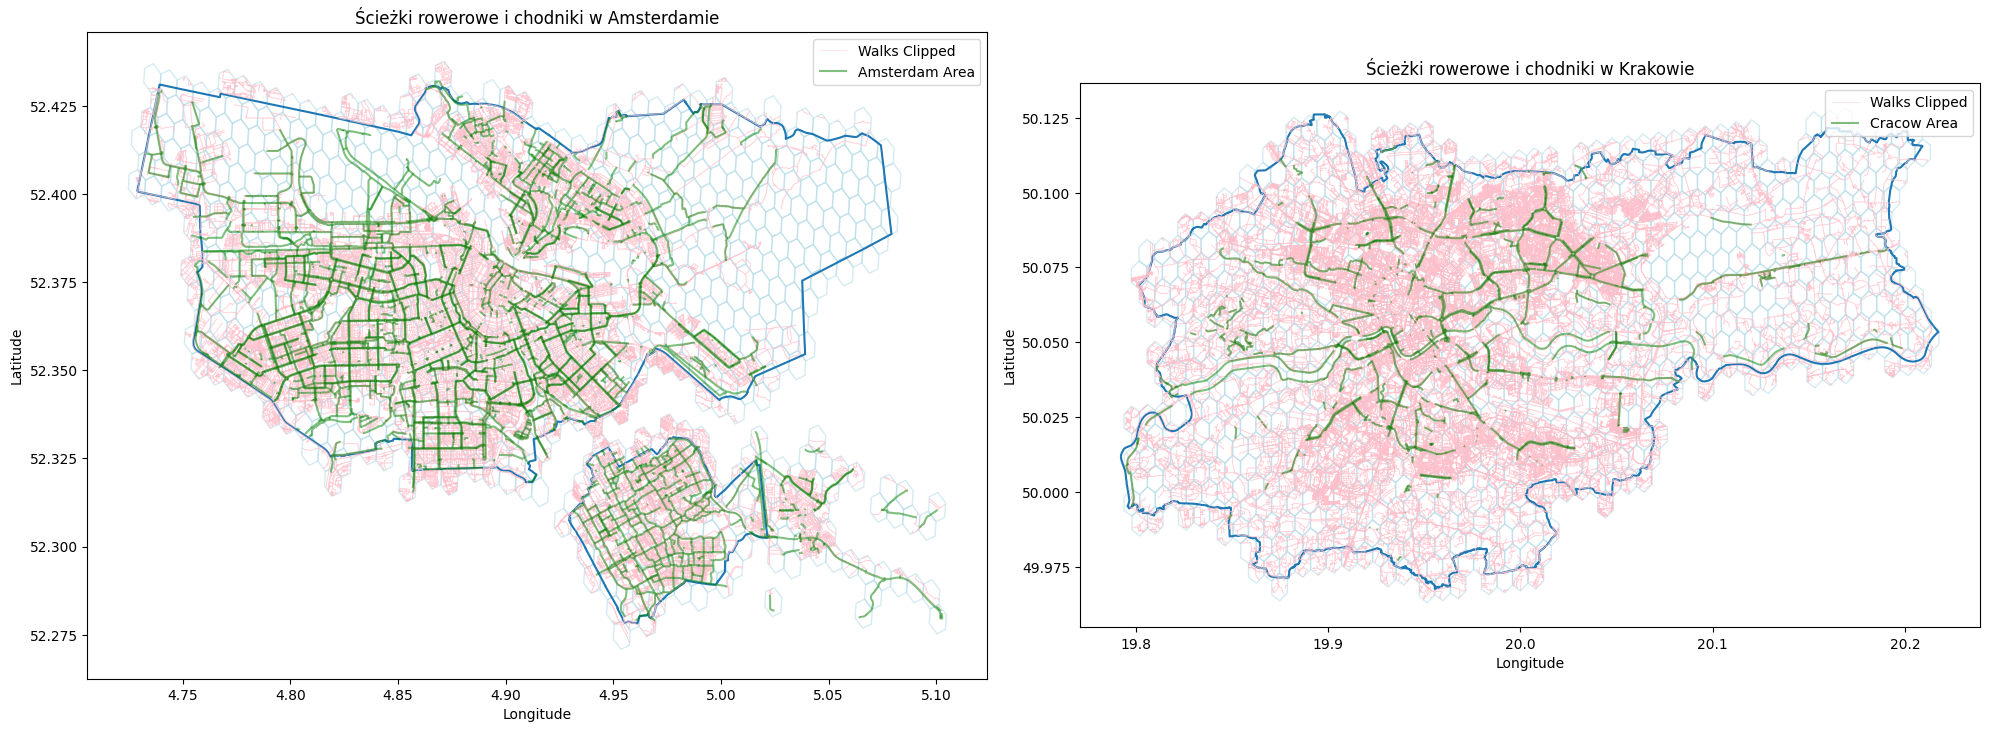

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # Adjusted figsize for better visibility
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
ams_walks_clipped.plot(ax=ax[0], edgecolor='pink', facecolor='none', alpha=0.5, linewidth=0.6, label='Walks Clipped')
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5, label='Amsterdam Area')

ax[0].set_title('Ścieżki rowerowe i chodniki w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].legend()

cracow_area['geometry'].boundary.plot(ax=ax[1])
krk_walks_clipped.plot(ax=ax[1], edgecolor='pink', facecolor='none', alpha=0.5, linewidth=0.6, label='Walks Clipped')
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5, label='Cracow Area')

ax[1].set_title('Ścieżki rowerowe i chodniki w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].legend()

plt.tight_layout()
plt.show()


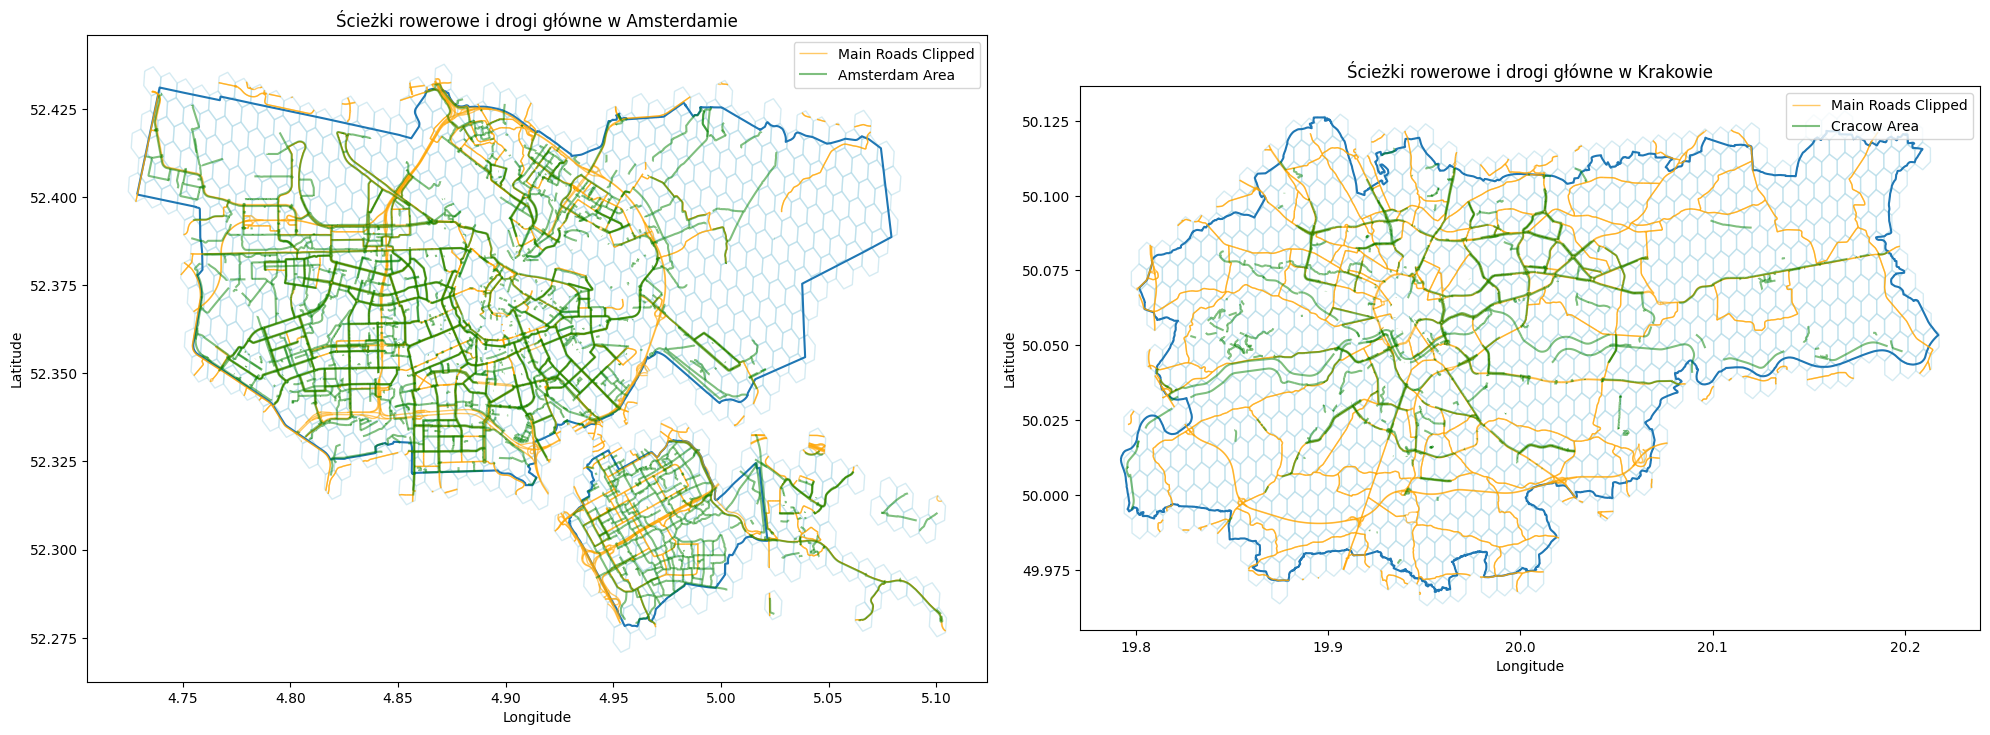

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # Adjusted figsize for better visibility
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
ams_roads_main_clipped.plot(ax=ax[0], edgecolor='orange', facecolor='none', alpha=0.6, linewidth=1, label='Main Roads Clipped')
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5, label='Amsterdam Area')

ax[0].set_title('Ścieżki rowerowe i drogi główne w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].legend()

cracow_area['geometry'].boundary.plot(ax=ax[1])
krk_roads_main_clipped.plot(ax=ax[1], edgecolor='orange', facecolor='none', alpha=0.6, linewidth=1, label='Main Roads Clipped')
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5, label='Cracow Area')

ax[1].set_title('Ścieżki rowerowe i drogi główne w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].legend()

plt.tight_layout()
plt.show()


#### - powierzchnia terenów zielonych

In [60]:
def calculate_green_space_areas(amsterdam_bounds, gdf_ams_hex, hex_area):
    # Get green spaces network
    Ams_green_spaces = ox.geometries_from_bbox(north=amsterdam_bounds['north'],
                                               south=amsterdam_bounds['south'],
                                               east=amsterdam_bounds['east'],
                                               west=amsterdam_bounds['west'],
                                               tags={'leisure': 'park',
                                                     'landuse': ['recreation_ground', 'forest'],
                                                     'natural': 'wood'})

    # Clip to the hexagonal area
    ams_green_spaces_clipped = gpd.clip(Ams_green_spaces, hex_area)

    # Project to the appropriate CRS
    gdf_ams_hex = gdf_ams_hex.to_crs(epsg=28992)
    ams_green_spaces_clipped_proj = ams_green_spaces_clipped.to_crs(epsg=28992)

    # Initialize area columns
    gdf_ams_hex['green_space_area'] = 0.0

    # Calculate areas for each hexagon
    for i, polygon in gdf_ams_hex.iterrows():
        clipped_g = gpd.clip(ams_green_spaces_clipped_proj, polygon.geometry)
        gdf_ams_hex.at[i, 'green_space_area'] = clipped_g.area.sum()

    # Reproject back to the original CRS
    gdf_ams_hex = gdf_ams_hex.to_crs(epsg=4326)

    return gdf_ams_hex, ams_green_spaces_clipped

In [61]:
hex_area_ams = unary_union(gdf_ams_hex.geometry)
gdf_ams_hex,ams_green_spaces_clipped = calculate_green_space_areas(amsterdam_bounds,gdf_ams_hex, hex_area_ams)
gdf_ams_hex

geometry         h3_index  \
0     POLYGON ((4.94029 52.36269, 4.94427 52.36389, ...  887ab60b33fffff   
1     POLYGON ((4.81067 52.41144, 4.81465 52.41264, ...  887ab6180dfffff   
2     POLYGON ((4.85620 52.36929, 4.86019 52.37049, ...  887ab618a5fffff   
3     POLYGON ((4.94420 52.29200, 4.94818 52.29321, ...  887ab608c1fffff   
4     POLYGON ((5.00176 52.36127, 5.00574 52.36247, ...  887ab646cbfffff   
...                                                 ...              ...   
1376  POLYGON ((4.80796 52.38669, 4.81195 52.38789, ...  887ab61819fffff   
1377  POLYGON ((4.86603 52.42410, 4.87002 52.42530, ...  887ab61933fffff   
1380  POLYGON ((4.76106 52.41648, 4.76505 52.41768, ...  887ab61a01fffff   
1383  POLYGON ((4.85215 52.33214, 4.85614 52.33334, ...  887ab6016dfffff   
1386  POLYGON ((5.00703 52.30299, 5.01101 52.30419, ...  887ab609bbfffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  
0          2947.034061        4205.575078  18874.219552      79625.277943  
1             0.000000           0.000000      0.000000          0.000000  
2          2252.128242        1605.670249  17633.708266        858.649975  
3           483.940561        6357.553849   4020.524307      34411.194925  
4           702.617398         619.061035    722.526016          0.000000  
...                ...                ...           ...               ...  
1376       2972.080397        2814.496048  13157.476291     186896.672378  
1377         80.911623        4475.886010  16817.678276      86040.252495  
1380        328.553654           0.000000   8527.682370       3484.865955  
1383       2704.204141        2435.258751  14754.288209     260486.052245  
1386          0.000000           0.000000   1593.645982      12413.235631  

[752 rows x 6 columns]

In [62]:
hex_area_krk = unary_union(gdf_krk_hex.geometry)
gdf_krk_hex,krk_green_spaces_clipped = calculate_green_space_areas(cracow_bounds,gdf_krk_hex, hex_area_krk)
gdf_krk_hex

C:\Users\Kowalski Krzysztof\AppData\Local\Temp\ipykernel_10948\3490342604.py:3: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  Ams_green_spaces = ox.geometries_from_bbox(north=amsterdam_bounds['north'],
C:\anaconda\Lib\site-packages\osmnx\geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)


geometry         h3_index  \
0     POLYGON ((19.99952 50.04525, 19.99550 50.04262...  885262c0c9fffff   
1     POLYGON ((19.90675 50.03072, 19.90273 50.02809...  885262ce29fffff   
2     POLYGON ((19.94317 50.01301, 19.93915 50.01038...  885262c19dfffff   
3     POLYGON ((20.14051 50.10525, 20.13649 50.10261...  885262d449fffff   
4     POLYGON ((20.00368 50.02488, 19.99965 50.02225...  885262c019fffff   
...                                                 ...              ...   
1207  POLYGON ((19.93053 50.11542, 19.92651 50.11279...  885262c517fffff   
1210  POLYGON ((19.90275 50.02349, 19.89873 50.02086...  885262ce2dfffff   
1213  POLYGON ((19.80996 50.02276, 19.80594 50.02013...  885262cdebfffff   
1215  POLYGON ((19.93116 49.99132, 19.92714 49.98869...  885262c1abfffff   
1217  POLYGON ((19.99529 50.07941, 19.99127 50.07678...  885262c767fffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  
0             0.000000           0.000000  19720.213661     113398.247201  
1           529.324034           0.000000  20431.576053     122407.709248  
2          1388.364807        1359.036481  25085.317972      86553.980482  
3             0.000000           0.000000   5478.280703       6378.097441  
4             0.000000         618.945599  23608.194020      36322.325395  
...                ...                ...           ...               ...  
1207          0.000000        1192.049590  19195.628206      49783.138252  
1210       1403.052406        1142.009019  21437.359169      88815.351700  
1213        511.863124           0.000000   8239.788806      61167.552518  
1215          0.000000        1886.893898   9392.822056     120963.335583  
1217        422.841644           0.000000  24913.510823     190559.044512  

[841 rows x 6 columns]

C:\Users\Kowalski Krzysztof\AppData\Local\Temp\ipykernel_10948\2189562412.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[0].legend()
C:\Users\Kowalski Krzysztof\AppData\Local\Temp\ipykernel_10948\2189562412.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[1].legend()


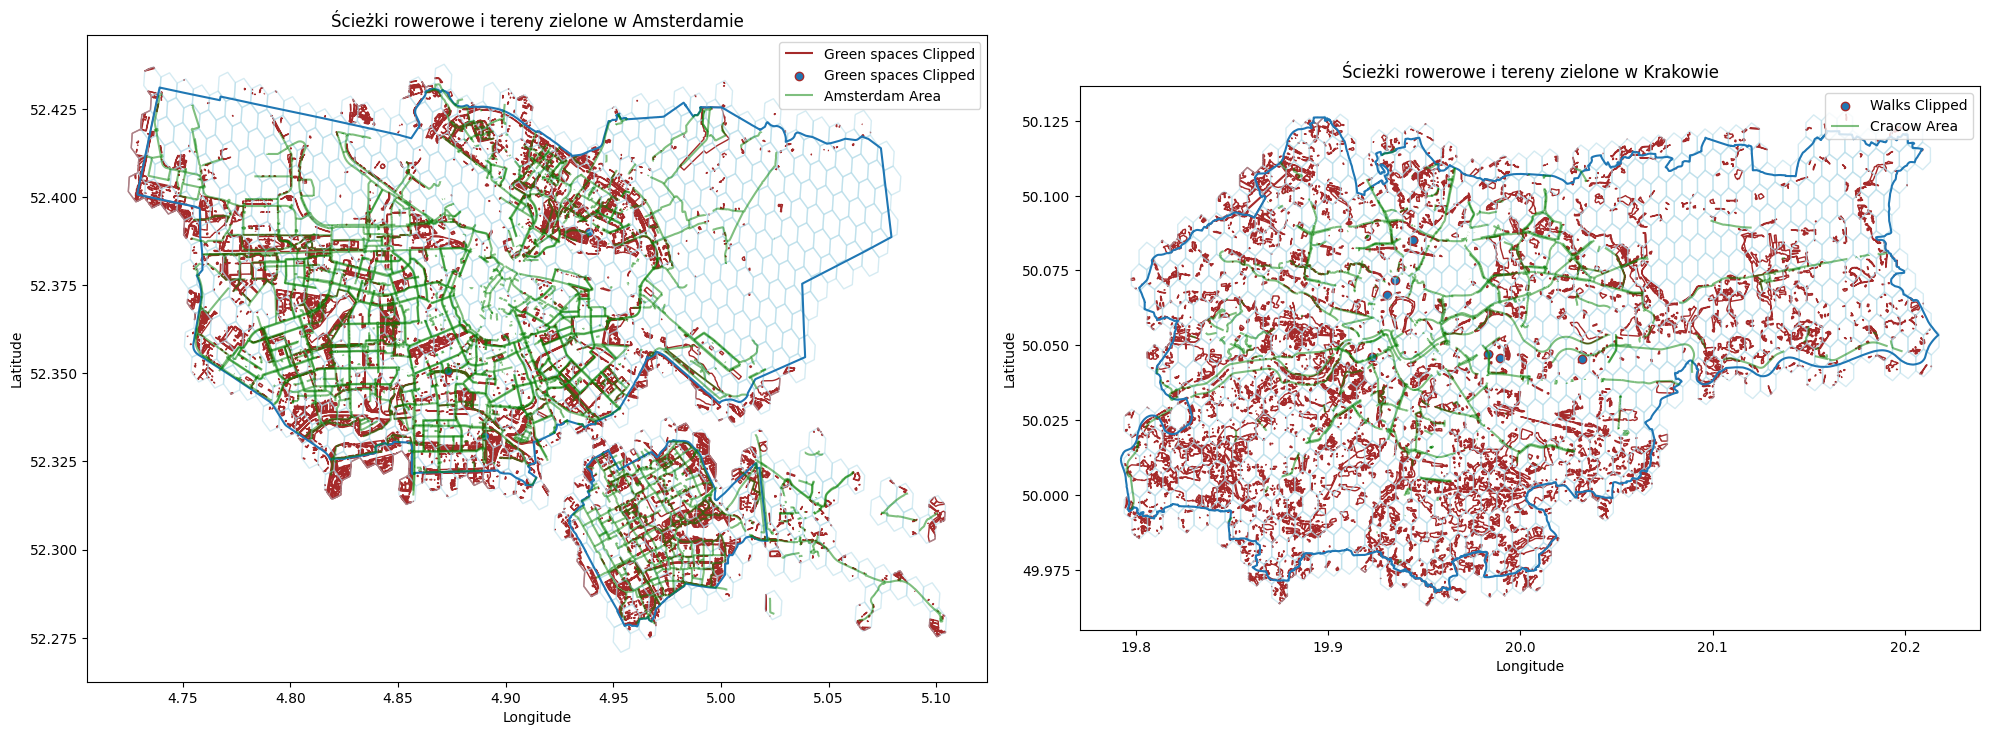

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # Adjusted figsize for better visibility
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
ams_green_spaces_clipped.plot(ax=ax[0], edgecolor='brown', facecolor='none', alpha=1, label='Green spaces Clipped')
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5, label='Amsterdam Area')

ax[0].set_title('Ścieżki rowerowe i tereny zielone w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].legend()

cracow_area['geometry'].boundary.plot(ax=ax[1])
krk_green_spaces_clipped.plot(ax=ax[1], edgecolor='brown', facecolor='none', alpha=1, label='Walks Clipped')
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5, label='Cracow Area')

ax[1].set_title('Ścieżki rowerowe i tereny zielone w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].legend()

plt.tight_layout()
plt.show()


#### - odległość od centrum miasta

In [65]:
def get_city_center(city_name):
    geolocator = Nominatim(user_agent="city_center_locator")
    location = geolocator.geocode(city_name)
    center_gdf = gpd.GeoDataFrame(geometry=[Point(location.longitude, location.latitude)],crs=4326) 
    if location:
        return center_gdf
    else:
        return None
center_amsterdam = get_city_center("Amsterdam, Netherlands")
center_cracow = get_city_center("Kraków, Poland")
center_amsterdam, center_cracow

(                   geometry
 0  POINT (4.89245 52.37308),
                     geometry
 0  POINT (19.99715 50.04694))

In [66]:
def distance_to_city_center(hex_gdf, center_gdf, epsg=28992):
    old_epsg = hex_gdf.crs.to_epsg()
    center_gdf_proj = center_gdf.to_crs(epsg=epsg)
    hex_gdf = hex_gdf.to_crs(epsg=epsg)
    hex_gdf['distance_to_city_center'] = hex_gdf.geometry.centroid.distance(center_gdf_proj.iloc[0,0])
    hex_gdf = hex_gdf.to_crs(epsg=old_epsg)
    return hex_gdf
    
gdf_ams_hex = distance_to_city_center(gdf_ams_hex, center_amsterdam)
gdf_krk_hex = distance_to_city_center(gdf_krk_hex, center_cracow)

gdf_ams_hex

geometry         h3_index  \
0     POLYGON ((4.94029 52.36269, 4.94427 52.36389, ...  887ab60b33fffff   
1     POLYGON ((4.81067 52.41144, 4.81465 52.41264, ...  887ab6180dfffff   
2     POLYGON ((4.85620 52.36929, 4.86019 52.37049, ...  887ab618a5fffff   
3     POLYGON ((4.94420 52.29200, 4.94818 52.29321, ...  887ab608c1fffff   
4     POLYGON ((5.00176 52.36127, 5.00574 52.36247, ...  887ab646cbfffff   
...                                                 ...              ...   
1376  POLYGON ((4.80796 52.38669, 4.81195 52.38789, ...  887ab61819fffff   
1377  POLYGON ((4.86603 52.42410, 4.87002 52.42530, ...  887ab61933fffff   
1380  POLYGON ((4.76106 52.41648, 4.76505 52.41768, ...  887ab61a01fffff   
1383  POLYGON ((4.85215 52.33214, 4.85614 52.33334, ...  887ab6016dfffff   
1386  POLYGON ((5.00703 52.30299, 5.01101 52.30419, ...  887ab609bbfffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  \
0          2947.034061        4205.575078  18874.219552      79625.277943   
1             0.000000           0.000000      0.000000          0.000000   
2          2252.128242        1605.670249  17633.708266        858.649975   
3           483.940561        6357.553849   4020.524307      34411.194925   
4           702.617398         619.061035    722.526016          0.000000   
...                ...                ...           ...               ...   
1376       2972.080397        2814.496048  13157.476291     186896.672378   
1377         80.911623        4475.886010  16817.678276      86040.252495   
1380        328.553654           0.000000   8527.682370       3484.865955   
1383       2704.204141        2435.258751  14754.288209     260486.052245   
1386          0.000000           0.000000   1593.645982      12413.235631   

      distance_to_city_center  
0                 3799.726484  
1                 6627.373681  
2                 2349.837708  
3                10077.559802  
4                 7858.604939  
...                       ...  
1376              5639.292448  
1377              5573.879712  
1380              9799.249892  
1383              5485.846229  
1386             11437.315854  

[752 rows x 7 columns]

In [68]:
gdf_krk_hex

geometry         h3_index  \
0     POLYGON ((19.99952 50.04525, 19.99550 50.04262...  885262c0c9fffff   
1     POLYGON ((19.90675 50.03072, 19.90273 50.02809...  885262ce29fffff   
2     POLYGON ((19.94317 50.01301, 19.93915 50.01038...  885262c19dfffff   
3     POLYGON ((20.14051 50.10525, 20.13649 50.10261...  885262d449fffff   
4     POLYGON ((20.00368 50.02488, 19.99965 50.02225...  885262c019fffff   
...                                                 ...              ...   
1207  POLYGON ((19.93053 50.11542, 19.92651 50.11279...  885262c517fffff   
1210  POLYGON ((19.90275 50.02349, 19.89873 50.02086...  885262ce2dfffff   
1213  POLYGON ((19.80996 50.02276, 19.80594 50.02013...  885262cdebfffff   
1215  POLYGON ((19.93116 49.99132, 19.92714 49.98869...  885262c1abfffff   
1217  POLYGON ((19.99529 50.07941, 19.99127 50.07678...  885262c767fffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  \
0             0.000000           0.000000  19720.213661     113398.247201   
1           529.324034           0.000000  20431.576053     122407.709248   
2          1388.364807        1359.036481  25085.317972      86553.980482   
3             0.000000           0.000000   5478.280703       6378.097441   
4             0.000000         618.945599  23608.194020      36322.325395   
...                ...                ...           ...               ...   
1207          0.000000        1192.049590  19195.628206      49783.138252   
1210       1403.052406        1142.009019  21437.359169      88815.351700   
1213        511.863124           0.000000   8239.788806      61167.552518   
1215          0.000000        1886.893898   9392.822056     120963.335583   
1217        422.841644           0.000000  24913.510823     190559.044512   

      distance_to_city_center  
0                  124.945220  
1                 6995.178404  
2                 5507.195172  
3                12096.316500  
4                 2256.644710  
...                       ...  
1207              9387.245734  
1210              7496.113330  
1213             14013.207253  
1215              7850.111864  
1217              3878.980686  

[841 rows x 7 columns]

C:\Users\Kowalski Krzysztof\AppData\Local\Temp\ipykernel_10948\3037703094.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[0].legend()
C:\Users\Kowalski Krzysztof\AppData\Local\Temp\ipykernel_10948\3037703094.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[1].legend()


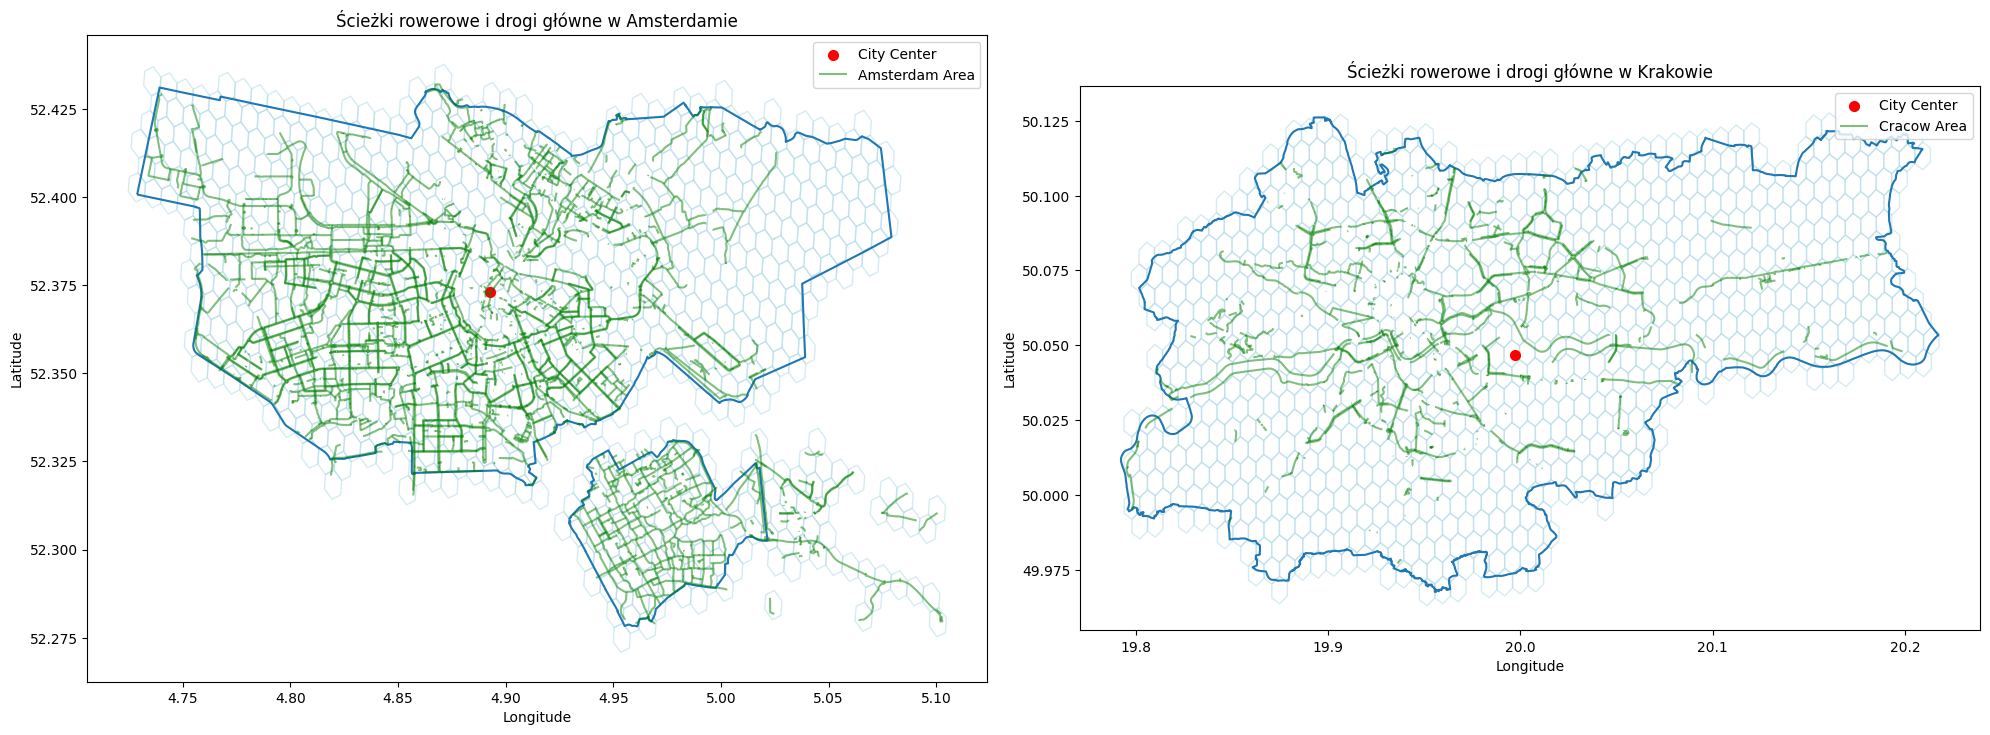

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # Adjusted figsize for better visibility
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
center_amsterdam.plot(ax=ax[0], color="red", linewidth=2, label='City Center')
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5, label='Amsterdam Area')

ax[0].set_title('Ścieżki rowerowe i drogi główne w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].legend()

cracow_area['geometry'].boundary.plot(ax=ax[1])
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
center_cracow.plot(ax=ax[1], color='red', linewidth=2, label='City Center')
gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5, label='Cracow Area')

ax[1].set_title('Ścieżki rowerowe i drogi główne w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].legend()

plt.tight_layout()
plt.show()


#### - ilość lokali usługowych

In [71]:
def calculate_service_amenities(amsterdam_bounds, gdf_ams_hex, hex_area):
    # Get service amenities
    service_amenity_tags = {
        'amenity': True,  # Includes a variety of amenities like restaurants, cafes, schools, etc.
        'shop': True,     # Includes various types of shops
        'office': True    # Includes office buildings
    }
    
    Ams_service_amenities = ox.geometries_from_bbox(north=amsterdam_bounds['north'],
                                                    south=amsterdam_bounds['south'],
                                                    east=amsterdam_bounds['east'],
                                                    west=amsterdam_bounds['west'],
                                                    tags=service_amenity_tags)

    # Clip to the hexagonal area
    ams_service_amenities_clipped = gpd.clip(Ams_service_amenities, hex_area)

    # Initialize a column for counting amenities
    gdf_ams_hex['service_amenity_count'] = 0

    # Calculate the number of amenities for each hexagon
    for i, polygon in gdf_ams_hex.iterrows():
        clipped_amenities = gpd.clip(ams_service_amenities_clipped, polygon.geometry)
        gdf_ams_hex.at[i, 'service_amenity_count'] = clipped_amenities.shape[0]

    return gdf_ams_hex, ams_service_amenities_clipped

In [72]:
hex_area_ams = unary_union(gdf_ams_hex.geometry)
gdf_ams_hex,ams_service_amenities_clipped = calculate_service_amenities(amsterdam_bounds,gdf_ams_hex, hex_area_ams)
gdf_ams_hex

C:\Users\Kowalski Krzysztof\AppData\Local\Temp\ipykernel_10948\3436094543.py:9: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  Ams_service_amenities = ox.geometries_from_bbox(north=amsterdam_bounds['north'],
C:\anaconda\Lib\site-packages\osmnx\geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)


geometry         h3_index  \
0     POLYGON ((4.94029 52.36269, 4.94427 52.36389, ...  887ab60b33fffff   
1     POLYGON ((4.81067 52.41144, 4.81465 52.41264, ...  887ab6180dfffff   
2     POLYGON ((4.85620 52.36929, 4.86019 52.37049, ...  887ab618a5fffff   
3     POLYGON ((4.94420 52.29200, 4.94818 52.29321, ...  887ab608c1fffff   
4     POLYGON ((5.00176 52.36127, 5.00574 52.36247, ...  887ab646cbfffff   
...                                                 ...              ...   
1376  POLYGON ((4.80796 52.38669, 4.81195 52.38789, ...  887ab61819fffff   
1377  POLYGON ((4.86603 52.42410, 4.87002 52.42530, ...  887ab61933fffff   
1380  POLYGON ((4.76106 52.41648, 4.76505 52.41768, ...  887ab61a01fffff   
1383  POLYGON ((4.85215 52.33214, 4.85614 52.33334, ...  887ab6016dfffff   
1386  POLYGON ((5.00703 52.30299, 5.01101 52.30419, ...  887ab609bbfffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  \
0          2947.034061        4205.575078  18874.219552      79625.277943   
1             0.000000           0.000000      0.000000          0.000000   
2          2252.128242        1605.670249  17633.708266        858.649975   
3           483.940561        6357.553849   4020.524307      34411.194925   
4           702.617398         619.061035    722.526016          0.000000   
...                ...                ...           ...               ...   
1376       2972.080397        2814.496048  13157.476291     186896.672378   
1377         80.911623        4475.886010  16817.678276      86040.252495   
1380        328.553654           0.000000   8527.682370       3484.865955   
1383       2704.204141        2435.258751  14754.288209     260486.052245   
1386          0.000000           0.000000   1593.645982      12413.235631   

      distance_to_city_center  service_amenity_count  
0                 3799.726484                    169  
1                 6627.373681                      0  
2                 2349.837708                    111  
3                10077.559802                     41  
4                 7858.604939                      2  
...                       ...                    ...  
1376              5639.292448                     10  
1377              5573.879712                      6  
1380              9799.249892                      3  
1383              5485.846229                     19  
1386             11437.315854                      3  

[752 rows x 8 columns]

In [73]:
hex_area_krk = unary_union(gdf_krk_hex.geometry)
gdf_krk_hex,krk_service_amenities_clipped = calculate_service_amenities(cracow_bounds,gdf_krk_hex, hex_area_krk)
gdf_krk_hex

C:\Users\Kowalski Krzysztof\AppData\Local\Temp\ipykernel_10948\3436094543.py:9: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  Ams_service_amenities = ox.geometries_from_bbox(north=amsterdam_bounds['north'],
C:\anaconda\Lib\site-packages\osmnx\geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)


geometry         h3_index  \
0     POLYGON ((19.99952 50.04525, 19.99550 50.04262...  885262c0c9fffff   
1     POLYGON ((19.90675 50.03072, 19.90273 50.02809...  885262ce29fffff   
2     POLYGON ((19.94317 50.01301, 19.93915 50.01038...  885262c19dfffff   
3     POLYGON ((20.14051 50.10525, 20.13649 50.10261...  885262d449fffff   
4     POLYGON ((20.00368 50.02488, 19.99965 50.02225...  885262c019fffff   
...                                                 ...              ...   
1207  POLYGON ((19.93053 50.11542, 19.92651 50.11279...  885262c517fffff   
1210  POLYGON ((19.90275 50.02349, 19.89873 50.02086...  885262ce2dfffff   
1213  POLYGON ((19.80996 50.02276, 19.80594 50.02013...  885262cdebfffff   
1215  POLYGON ((19.93116 49.99132, 19.92714 49.98869...  885262c1abfffff   
1217  POLYGON ((19.99529 50.07941, 19.99127 50.07678...  885262c767fffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  \
0             0.000000           0.000000  19720.213661     113398.247201   
1           529.324034           0.000000  20431.576053     122407.709248   
2          1388.364807        1359.036481  25085.317972      86553.980482   
3             0.000000           0.000000   5478.280703       6378.097441   
4             0.000000         618.945599  23608.194020      36322.325395   
...                ...                ...           ...               ...   
1207          0.000000        1192.049590  19195.628206      49783.138252   
1210       1403.052406        1142.009019  21437.359169      88815.351700   
1213        511.863124           0.000000   8239.788806      61167.552518   
1215          0.000000        1886.893898   9392.822056     120963.335583   
1217        422.841644           0.000000  24913.510823     190559.044512   

      distance_to_city_center  service_amenity_count  
0                  124.945220                     21  
1                 6995.178404                     30  
2                 5507.195172                     35  
3                12096.316500                      0  
4                 2256.644710                     56  
...                       ...                    ...  
1207              9387.245734                     25  
1210              7496.113330                     96  
1213             14013.207253                      1  
1215              7850.111864                      1  
1217              3878.980686                    120  

[841 rows x 8 columns]

C:\Users\Kowalski Krzysztof\AppData\Local\Temp\ipykernel_10948\2712504861.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[0].legend()
C:\Users\Kowalski Krzysztof\AppData\Local\Temp\ipykernel_10948\2712504861.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[1].legend()


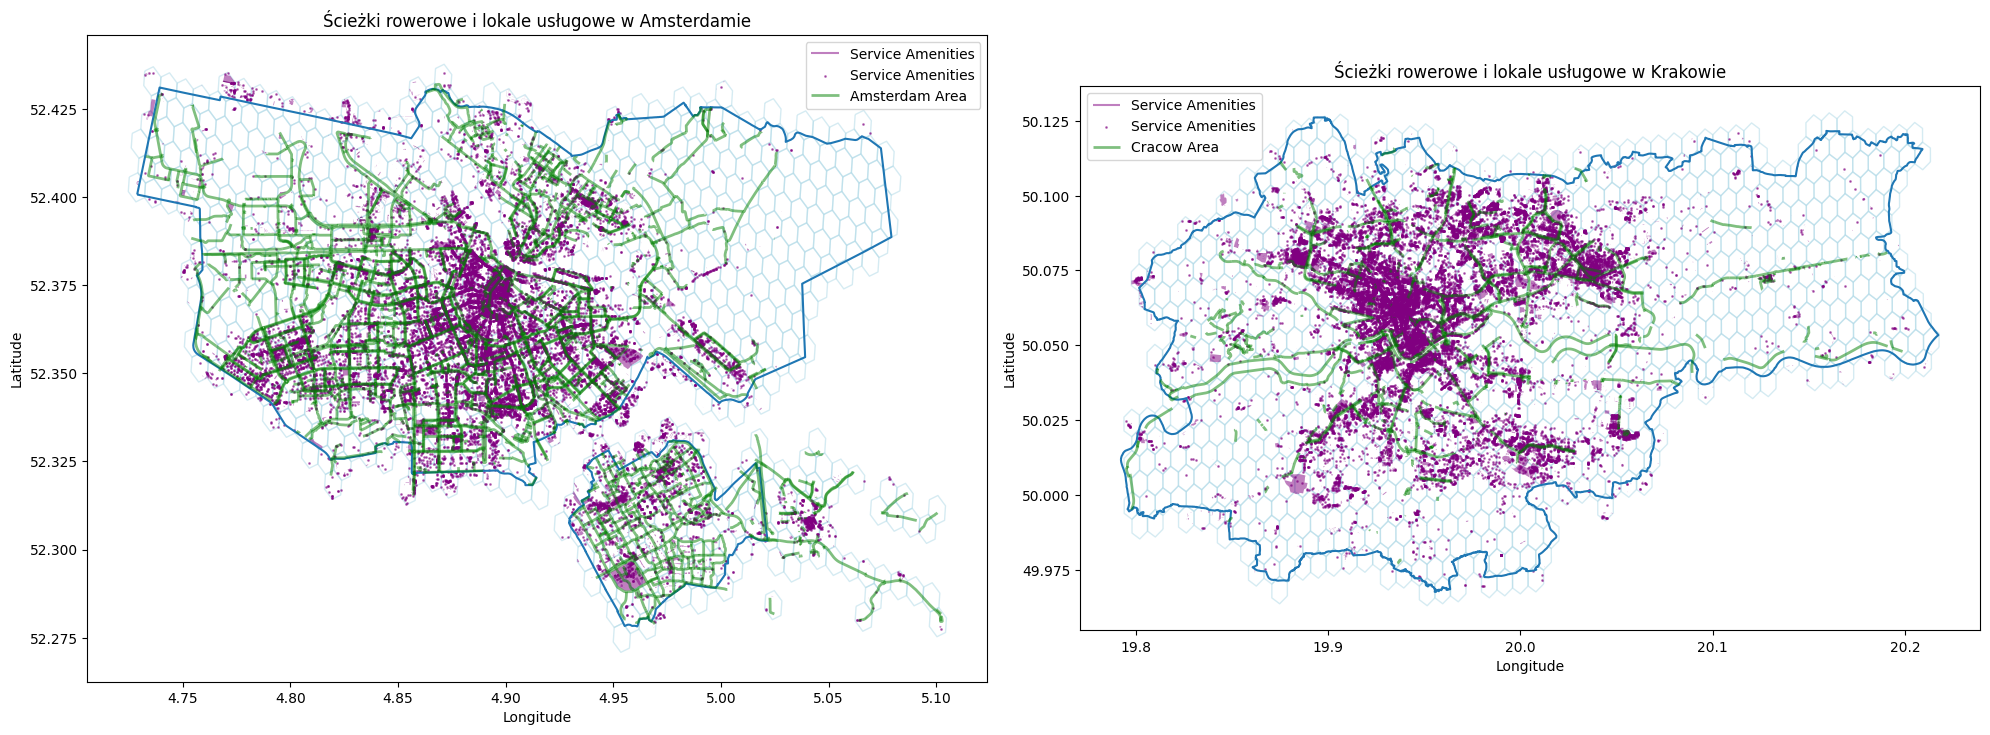

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # Adjusted figsize for better visibility

# Plot Amsterdam
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
ams_service_amenities_clipped.plot(ax=ax[0], color='purple', markersize=1, alpha=0.5, label='Service Amenities')
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5, linewidth=2, label='Amsterdam Area')

ax[0].set_title('Ścieżki rowerowe i lokale usługowe w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].legend()

# Plot Kraków
cracow_area['geometry'].boundary.plot(ax=ax[1])
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
krk_service_amenities_clipped.plot(ax=ax[1], color='purple', markersize=1, alpha=0.5, label='Service Amenities')
gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5, linewidth=2, label='Cracow Area')

ax[1].set_title('Ścieżki rowerowe i lokale usługowe w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].legend()

plt.tight_layout()
plt.show()


## Podsumowanie atrybutów

In [77]:
gdf_ams_hex.to_csv('gdf_ams_hex.csv', index=False)
gdf_krk_hex.to_csv('gdf_krk_hex.csv', index=False)

gdf_ams_hex

geometry         h3_index  \
0     POLYGON ((4.94029 52.36269, 4.94427 52.36389, ...  887ab60b33fffff   
1     POLYGON ((4.81067 52.41144, 4.81465 52.41264, ...  887ab6180dfffff   
2     POLYGON ((4.85620 52.36929, 4.86019 52.37049, ...  887ab618a5fffff   
3     POLYGON ((4.94420 52.29200, 4.94818 52.29321, ...  887ab608c1fffff   
4     POLYGON ((5.00176 52.36127, 5.00574 52.36247, ...  887ab646cbfffff   
...                                                 ...              ...   
1376  POLYGON ((4.80796 52.38669, 4.81195 52.38789, ...  887ab61819fffff   
1377  POLYGON ((4.86603 52.42410, 4.87002 52.42530, ...  887ab61933fffff   
1380  POLYGON ((4.76106 52.41648, 4.76505 52.41768, ...  887ab61a01fffff   
1383  POLYGON ((4.85215 52.33214, 4.85614 52.33334, ...  887ab6016dfffff   
1386  POLYGON ((5.00703 52.30299, 5.01101 52.30419, ...  887ab609bbfffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  \
0          2947.034061        4205.575078  18874.219552      79625.277943   
1             0.000000           0.000000      0.000000          0.000000   
2          2252.128242        1605.670249  17633.708266        858.649975   
3           483.940561        6357.553849   4020.524307      34411.194925   
4           702.617398         619.061035    722.526016          0.000000   
...                ...                ...           ...               ...   
1376       2972.080397        2814.496048  13157.476291     186896.672378   
1377         80.911623        4475.886010  16817.678276      86040.252495   
1380        328.553654           0.000000   8527.682370       3484.865955   
1383       2704.204141        2435.258751  14754.288209     260486.052245   
1386          0.000000           0.000000   1593.645982      12413.235631   

      distance_to_city_center  service_amenity_count  
0                 3799.726484                    169  
1                 6627.373681                      0  
2                 2349.837708                    111  
3                10077.559802                     41  
4                 7858.604939                      2  
...                       ...                    ...  
1376              5639.292448                     10  
1377              5573.879712                      6  
1380              9799.249892                      3  
1383              5485.846229                     19  
1386             11437.315854                      3  

[752 rows x 8 columns]

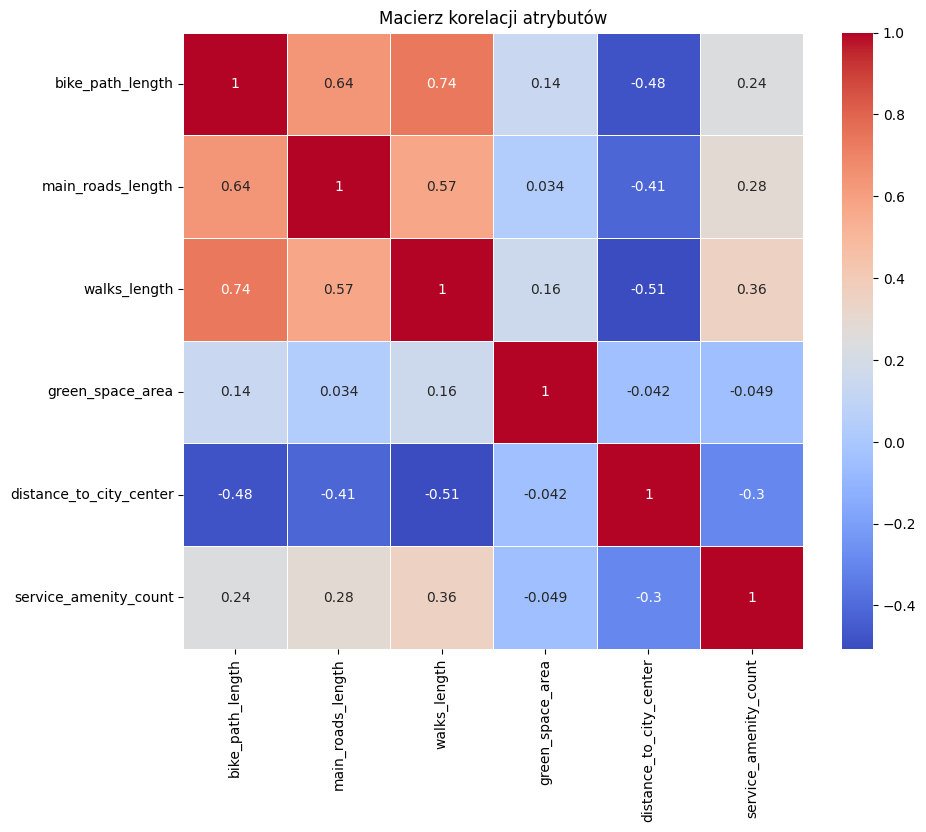

In [78]:
# Obliczanie macierzy korelacji
correlation_matrix = gdf_ams_hex[['bike_path_length','main_roads_length','walks_length','green_space_area','distance_to_city_center','service_amenity_count']].corr()

# Wizualizacja macierzy korelacji za pomocą heatmapy
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Macierz korelacji atrybutów')
plt.show()

## MLFlow

In [134]:
import mlflow
import mlflow.sklearn
import mlflow.tensorflow
import mlflow.pyfunc
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import contextily as ctx

In [110]:
# Split data into features and target variable
X = gdf_ams_hex.drop(['bike_path_length', 'geometry', 'h3_index'], axis = 1)
y = gdf_ams_hex['bike_path_length']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.4, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)

In [112]:
mlflow.set_experiment('Amsterdam_Bike_Paths_Prediction')

<Experiment: artifact_location='file:///C:/Users/Kowalski%20Krzysztof/Desktop/Krzysiek/Studia/Magisterskie/Semestr_I/Analiza_Danych_w_naukach_o_Ziemi/Laboratoria/Projekt_02/mlruns/633740021258586641', creation_time=1717946876298, experiment_id='633740021258586641', last_update_time=1717946876298, lifecycle_stage='active', name='Amsterdam_Bike_Paths_Prediction', tags={}>

In [114]:
def train_and_log_model(model, model_name, X_train, y_train, X_val, y_val):
    with mlflow.start_run(run_name=model_name):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        # Metryki
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        r2 = r2_score(y_val, y_pred)
        
        mlflow.log_metric('MAE', mae)
        mlflow.log_metric('MSE', mse)
        mlflow.log_metric('RMSE', rmse)
        mlflow.log_metric('R2', r2)
        
        mlflow.sklearn.log_model(model, model_name)
        print(f"{model_name} - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")

In [116]:
# Regresja liniowa
linear_regressor = LinearRegression()
train_and_log_model(linear_regressor, 'Linear Regression', X_train, y_train, X_val, y_val)

# Regresor wektorów nośnych (SVR)
svr_regressor = SVR()
train_and_log_model(svr_regressor, 'Support Vector Regressor', X_train, y_train, X_val, y_val)

# Las losowy
rf_regressor = RandomForestRegressor(random_state=42)
train_and_log_model(rf_regressor, 'Random Forest Regressor', X_train, y_train, X_val, y_val)

# Gradient Boosting Machines (GBM)
gbm_regressor = GradientBoostingRegressor(random_state=42)
train_and_log_model(gbm_regressor, 'Gradient Boosting Regressor', X_train, y_train, X_val, y_val)

C:\anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\anaconda\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
C:\anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Linear Regression - MAE: 517.9067963161334, MSE: 478367.47894126514, RMSE: 691.6411489647396, R2: 0.654573044486533
Support Vector Regressor - MAE: 960.8709370885292, MSE: 1375627.3002924805, RMSE: 1172.8713911987454, R2: 0.0066658558961429915


C:\anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest Regressor - MAE: 544.6657217941696, MSE: 537773.5584477582, RMSE: 733.3304565117681, R2: 0.6116761878098724


C:\anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Gradient Boosting Regressor - MAE: 541.2959076219411, MSE: 550067.2889613877, RMSE: 741.6652135305981, R2: 0.6027989415710087


In [120]:
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

with mlflow.start_run(run_name='RandomForest RandomizedSearch'):
    random_search.fit(X_train, y_train)
    
    best_model = random_search.best_estimator_
    mlflow.sklearn.log_model(best_model, 'RandomForest Best Model')
    
    mlflow.log_params(random_search.best_params_)
    
    y_pred = best_model.predict(X_val)
    
    #Metryki
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    r2 = r2_score(y_val, y_pred)
    
    mlflow.log_metric('MAE', mae)
    mlflow.log_metric('MSE', mse)
    mlflow.log_metric('RMSE', rmse)
    mlflow.log_metric('R2', r2)

    print(f"RandomForest Best Model - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
RandomForest Best Model - MAE: 522.3464502705805, MSE: 504957.37511948356, RMSE: 710.6035287834444, R2: 0.6353726027997583


C:\anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [122]:
X_krk = gdf_krk_hex.drop(['bike_path_length', 'geometry', 'h3_index'], axis=1)
y_krk_true = gdf_krk_hex['bike_path_length']

y_krk_pred = best_model.predict(X_krk)

In [124]:
mae_krk = mean_absolute_error(y_krk_true, y_krk_pred)
mse_krk = mean_squared_error(y_krk_true, y_krk_pred)
rmse_krk = mean_squared_error(y_krk_true, y_krk_pred, squared=False)
r2_krk = r2_score(y_krk_true, y_krk_pred)

print(f"Kraków - MAE: {mae_krk}, MSE: {mse_krk}, RMSE: {rmse_krk}, R2: {r2_krk}")

with mlflow.start_run(run_name='Krakow Prediction Evaluation'):
    mlflow.log_metric('MAE_Krakow', mae_krk)
    mlflow.log_metric('MSE_Krakow', mse_krk)
    mlflow.log_metric('RMSE_Krakow', rmse_krk)
    mlflow.log_metric('R2_Krakow', r2_krk)

Kraków - MAE: 905.6948136670574, MSE: 1160598.5989314248, RMSE: 1077.3108181631821, R2: -2.2701998269474952


C:\anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [126]:
X_ams = gdf_ams_hex.drop(['bike_path_length', 'geometry', 'h3_index'], axis=1)
y_ams = gdf_ams_hex['bike_path_length']
y_ams_pred = best_model.predict(X_ams)

# Dodanie przewidywanych wartości do GeoDataFrames
gdf_ams_hex['bike_path_length_pred'] = y_ams_pred
gdf_krk_hex['bike_path_length_pred'] = y_krk_pred

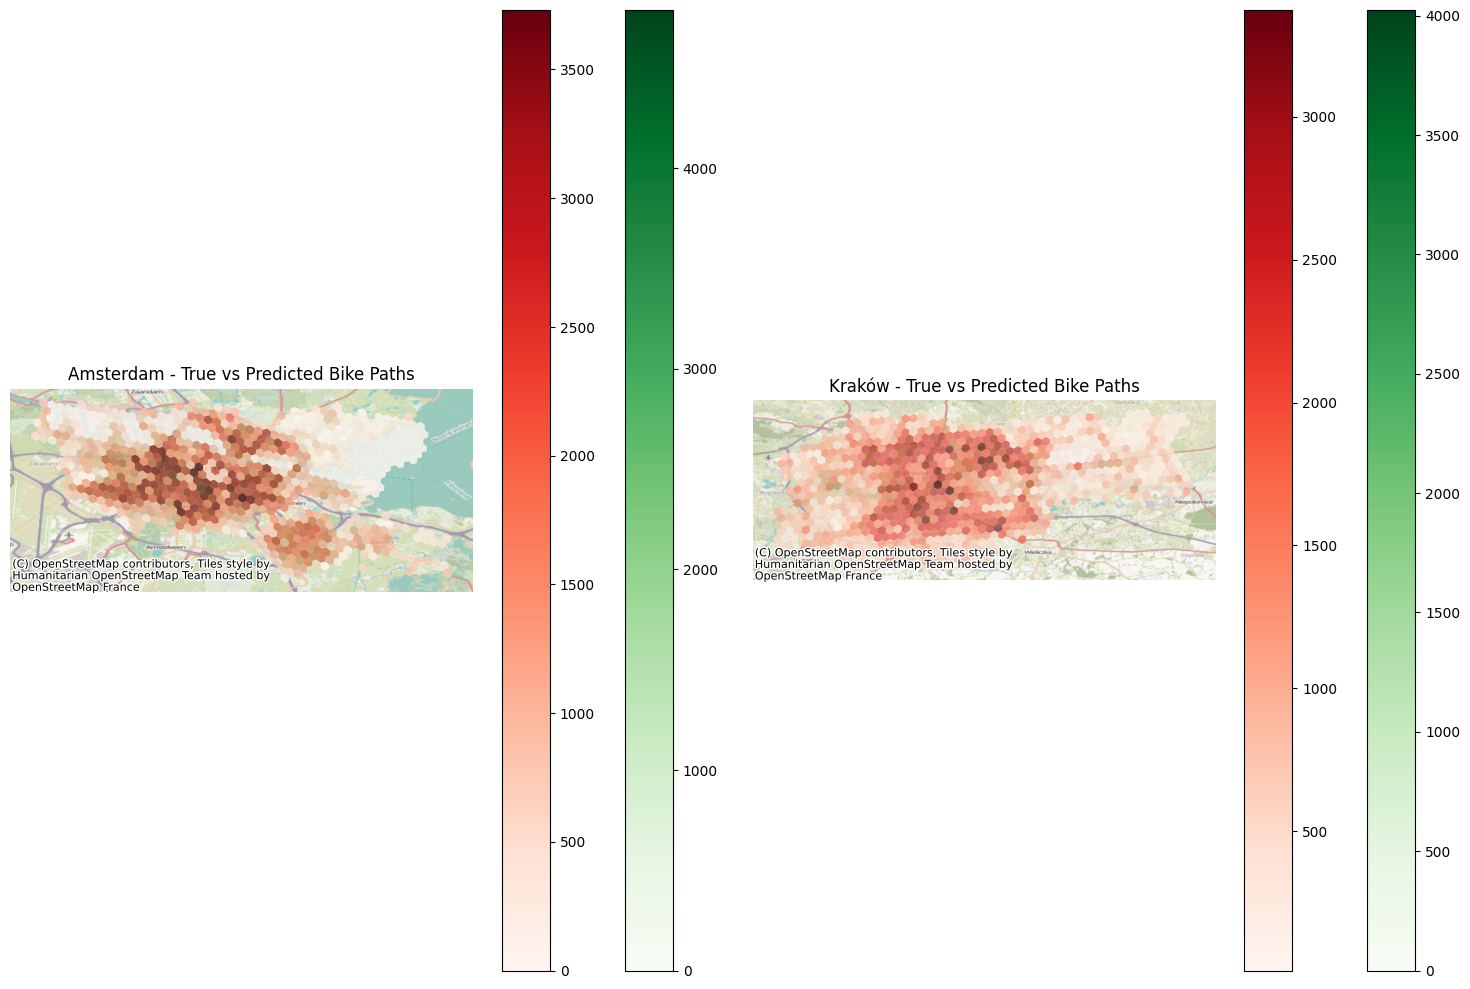

In [136]:
def plot_bike_paths(gdf, true_col, pred_col, title, ax):
    gdf.plot(column=true_col, cmap='Greens', legend=True, alpha=0.6, ax=ax)
    gdf.plot(column=pred_col, cmap='Reds', legend=True, alpha=0.6, ax=ax)
    ctx.add_basemap(ax, crs=gdf.crs.to_string())
    ax.set_title(title)
    ax.axis('off')

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Mapa dla Amsterdamu
plot_bike_paths(gdf_ams_hex, 'bike_path_length', 'bike_path_length_pred', 'Amsterdam - True vs Predicted Bike Paths', axes[0])

# Mapa dla Krakowa
plot_bike_paths(gdf_krk_hex, 'bike_path_length', 'bike_path_length_pred', 'Kraków - True vs Predicted Bike Paths', axes[1])

plt.tight_layout()